In [1]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from datetime import datetime

In [2]:
N = norm.cdf


In [3]:
def read_from_db():
    conn = sqlite3.connect('../../options_database.db')
    df = pd.read_sql_query("SELECT * FROM options_table", conn)
    conn.close()
    return df

In [4]:
df = read_from_db()

In [5]:
len(df[(df.current_time == '2023-01-29 11:24:46.988931')])

610

In [6]:
def delta_BS_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1) - 1

def delta_BS_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1)

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
#     print(d1, d2)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T)* N(-d2) - S * N(-d1)

In [7]:
BS_PUT(1000, 1000, 1, 0, 0.0000001)

3.989422810946053e-05

In [8]:
def get_timedelta_in_years(timedelta):
    d = timedelta.days / (365.25)
    s = timedelta.seconds / (365.25*24*60*60)
    return d + s

In [49]:
def preprocessing(option_name, option_type):
    selected_option = (df[(df.full_name == option_name)][df.current_time > '2023-01-04'][df.type == option_type])
    selected_option['timedelta'] = selected_option.apply(lambda x: get_timedelta_in_years(datetime.fromisoformat(x['expiry']) - datetime.fromisoformat(x['current_time'])), axis=1).astype(float)
    
    
    selected_option['mid_price'] = selected_option['mid_price'].fillna(0)
    selected_option['ask_price'] = selected_option['ask_price'].fillna(0)
    selected_option['bid_price'] = selected_option['bid_price'].fillna(0)
    selected_option['strike'] = selected_option['strike'].astype(float)
    # selected_option['mid_IV'] = selected_option['mid_IV'].fillna(0.001)
    
    
    filtered = selected_option.loc[(selected_option.bid_IV > 0) & (selected_option.bid_IV < 10) & 
                            (selected_option.ask_IV > 0) & (selected_option.ask_IV < 10) &
                             (selected_option.timedelta > 0)]
    
    
    # (selected_option.bid_IV < 10) & 
    #                                (selected_option.ask_IV < 10) &
    #                                (selected_option.mid_IV < 10) &
    
    # filtered = selected_option.loc[
    #                                (selected_option.timedelta > 0)]
    
    
    if option_type == 'put':
        filtered['BS_delta'] = delta_BS_put(filtered.underlying_price, filtered.strike, filtered.timedelta, 0, filtered.mid_IV)
    elif option_type == 'call':
        filtered['BS_delta'] = delta_BS_call(filtered.underlying_price, filtered.strike, filtered.timedelta, 0, filtered.mid_IV)
    
    filtered.index = np.arange(1, len(filtered)+1)
    
    return filtered



In [260]:
def backtest(df):
    
    swap_fee = 0.05 / 100
    tx_cost = 0.5 # in usdc
    
    asset = 0  
    initial_usdc = 0
    usdc = initial_usdc
    prev_asset = asset
    
    total_swap_fees = 0
    total_tx_costs = 0

    for i in range(len(df)):
        prev_asset = asset
        asset = df['BS_delta'].iloc[i]
        usdc = usdc - (asset - prev_asset) * df['underlying_price'].iloc[i] * (1 + swap_fee) - tx_cost
        
        total_swap_fees += abs(swap_fee * (asset - prev_asset)) * df['underlying_price'].iloc[i] 
        total_tx_costs += tx_cost
    
    print("total_swap_fees: {}, total_tx_costs: {}".format(total_swap_fees, total_tx_costs))
    return asset*df['underlying_price'].iloc[-1] + usdc - initial_usdc

In [261]:
# datetime.strptime(selected_put.iloc[5]['expiry'], "%Y %m %d %I:%M%p")
# get_timedelta_in_years(datetime.fromisoformat(selected_put.iloc[5]['expiry']) - datetime.fromisoformat(selected_put.iloc[5]['current_time']))


In [262]:
def calculate_option_PnL(init_underlying_price, final_underlying_price, 
                         strike, init_option_price_in_underlying, final_option_price_in_underlying):
    
    PnL = final_option_price_in_underlying * final_underlying_price - init_option_price_in_underlying * init_underlying_price
    return PnL


In [263]:
def test(option_name):
    filtered = preprocessing(option_name = option_name, option_type = 'put')
    # print(filtered['current_time'].iloc[0])
    return filtered
    
    replicated_pnl = backtest(filtered[filtered.index % 10 == 0])
    
    option_price = filtered['mid_price'].iloc[0] * filtered['underlying_price'].iloc[0]

    price_on_expiry = filtered['underlying_price'].iloc[-1]
    
    pnl = calculate_option_PnL(filtered['underlying_price'].iloc[-1], filtered['strike'].iloc[-1], filtered['mid_price'].iloc[0])

    
    return (replicated_pnl, pnl, price_on_expiry)

In [264]:
# (test('ETH-24FEB23-1400'))
# t[t['BS_delta'] < -1]

In [265]:
# def get_max_option_pnl(option_names):
#     max_pnl = -np.inf
#     for option_name in option_names:
#         filtered = preprocessing(option_name = option_name, option_type = 'put')
#         option_price = filtered['mid_price'].iloc[0] * filtered['underlying_price'].iloc[0]
#         price_on_expiry = filtered['underlying_price'].iloc[-1]
#         pnl = calculate_option_PnL(filtered['underlying_price'].iloc[-1], filtered['strike'].iloc[0], 
#                                filtered['mid_price'].iloc[0], filtered['mid_price'].iloc[-1])
        
#         if abs(pnl) > max_pnl:
#             max_pnl = abs(pnl)
    
#     return max_pnl
    

In [266]:
# df[df.index % 10 == 0]

In [267]:
len(df.index)-1

1098993

In [268]:
option_name

'ETH-24FEB23-1700'

In [269]:
# __filtered

In [270]:
# __filtered = preprocessing(option_name = option_name, option_type = 'put')
# __filtered = __filtered[(__filtered.index == len(__filtered.index) - 1) | (__filtered.index % 5 == 0)]
# print(__filtered['timedelta'].mean()*24)
# print(__filtered['timedelta'].std()*24)

## Performace

We cannot just say that performance = replicated_pnl / option_pnl, because sometimes replicated pnl is positive but option_pnl is negative. So the performance calculates as follows:

$$P = \frac{replicated\:pnl + \Delta}{option\:pnl + \Delta}$$

where

$$\Delta =  2 \cdot \max \{abs(replicated\:pnl),\: abs(option\: pnl)\} $$

In [271]:
def performance(option_name):
    
    filtered = preprocessing(option_name = option_name, option_type = 'put')
    filtered = filtered[(filtered.index == len(filtered.index) - 1) | (filtered.index % 18 == 0)]
    replicated_pnl = backtest(filtered)
    
    init_option_price = filtered['mid_price'].iloc[0] * filtered['underlying_price'].iloc[0]

    final_option_price = filtered['mid_price'].iloc[-1] * filtered['underlying_price'].iloc[-1]
    
    initial_price = filtered['underlying_price'].iloc[0]

    pnl = calculate_option_PnL(filtered['underlying_price'].iloc[0], filtered['underlying_price'].iloc[-1], filtered['strike'].iloc[0], 
                               filtered['mid_price'].iloc[0], filtered['mid_price'].iloc[-1])
    # print('------')
    print('option_name:', option_name)
    print('average time between replications (hrs): {}'.format(get_timedelta_in_years(datetime.fromisoformat(filtered['current_time'].iloc[-1]) - datetime.fromisoformat(filtered['current_time'].iloc[0])) / len(filtered['current_time']) * 365 * 24))
    print('start time:', filtered['current_time'].iloc[0])
    print('init_option_price: {}, final_option_price: {}'.format(init_option_price, final_option_price))
    print("rep_pnl: {}, initial_price: {}, pnl: {}".format(replicated_pnl, initial_price, pnl))
    print('------')

    shift = 2 * max(abs(replicated_pnl), abs(pnl))
    
    # if pnl > 0:
    #     if replicated_pnl > 0:

    #     else:
    #         return 
    # else:
    #     if replicated_pnl > 0:
    #         return (replicated_pnl + pnl) / pnl
    #     else:
    #         return pnl / replicated_pnl
    
    return [option_name, (replicated_pnl + shift) / (pnl + shift)]


In [272]:
# df.full_name.drop_duplicates().to_numpy()

In [273]:
options_names = ['ETH-27JAN23-1200', 'ETH-27JAN23-1300', 'ETH-27JAN23-1400', 'ETH-27JAN23-1500', 'ETH-27JAN23-1600', 'ETH-27JAN23-1700']

options_names = options_names + ['ETH-24FEB23-900', 'ETH-24FEB23-1000', 'ETH-24FEB23-1100', 'ETH-24FEB23-1200', 'ETH-24FEB23-1300', 'ETH-24FEB23-1400',
                'ETH-24FEB23-1500', 'ETH-24FEB23-1600', 'ETH-24FEB23-1700']

In [274]:
options_names

['ETH-27JAN23-1200',
 'ETH-27JAN23-1300',
 'ETH-27JAN23-1400',
 'ETH-27JAN23-1500',
 'ETH-27JAN23-1600',
 'ETH-27JAN23-1700',
 'ETH-24FEB23-900',
 'ETH-24FEB23-1000',
 'ETH-24FEB23-1100',
 'ETH-24FEB23-1200',
 'ETH-24FEB23-1300',
 'ETH-24FEB23-1400',
 'ETH-24FEB23-1500',
 'ETH-24FEB23-1600',
 'ETH-24FEB23-1700']

In [275]:
# shift = get_max_option_pnl(options_names)

In [276]:
# shift

In [277]:
import warnings
warnings.filterwarnings("ignore")

In [278]:
res = []

for option_name in options_names:
    # print(option_name)
    res.append(performance(option_name))

total_swap_fees: 0.7180531622575522, total_tx_costs: 34.5
option_name: ETH-27JAN23-1200
average time between replications (hrs): 7.257605526843392
start time: 2023-01-04 07:17:27.002615
init_option_price: 42.58160000000001, final_option_price: 1.152285
rep_pnl: -84.95065780630891, initial_price: 1252.4, pnl: -41.42931500000001
------
total_swap_fees: 1.2417925311594096, total_tx_costs: 38.0
option_name: ETH-27JAN23-1300
average time between replications (hrs): 6.672217268873759
start time: 2023-01-04 07:17:27.002615
init_option_price: 91.1121, final_option_price: 1.1670749999999999
rep_pnl: -143.01413850778906, initial_price: 1252.4, pnl: -89.945025
------
total_swap_fees: 1.612990378533278, total_tx_costs: 38.0
option_name: ETH-27JAN23-1400
average time between replications (hrs): 6.907217128779054
start time: 2023-01-04 07:17:27.002615
init_option_price: 165.943, final_option_price: 1.219035
rep_pnl: -220.44887015374528, initial_price: 1252.4, pnl: -164.72396500000002
------
total_sw

In [279]:
res

[['ETH-27JAN23-1200', 0.6612386932656322],
 ['ETH-27JAN23-1300', 0.7293541750135146],
 ['ETH-27JAN23-1400', 0.7982252113123289],
 ['ETH-27JAN23-1500', 0.8142661562478188],
 ['ETH-27JAN23-1600', 0.8334899757377146],
 ['ETH-27JAN23-1700', 0.8168290848452252],
 ['ETH-24FEB23-900', 0.5681859088596461],
 ['ETH-24FEB23-1000', 0.5989079193913251],
 ['ETH-24FEB23-1100', 0.6396477957443305],
 ['ETH-24FEB23-1200', 0.6901702800036884],
 ['ETH-24FEB23-1300', 0.7364472882930418],
 ['ETH-24FEB23-1400', 0.7808439520638306],
 ['ETH-24FEB23-1500', 0.784666609438995],
 ['ETH-24FEB23-1600', 0.8212293644950164],
 ['ETH-24FEB23-1700', 1.1616230520170572]]

In [280]:
print(np.mean(list(map(lambda x: x[1], res[:-1]))))
print(np.std(list(map(lambda x: x[1], res[:-1]))))

0.7338216010508648
0.08518289999857656


In [281]:
# filtered

#### Todo: run multiple replications (for diff strike, expiries) and draw a performance distribution

In [282]:
import plotly.graph_objs as go
import plotly.express as px

In [283]:
# fig = px.bar(res[0], x=np.array([res[0][0]]), y=np.array([res[1][1]]), title="Long-Form Input")

# fig.show()

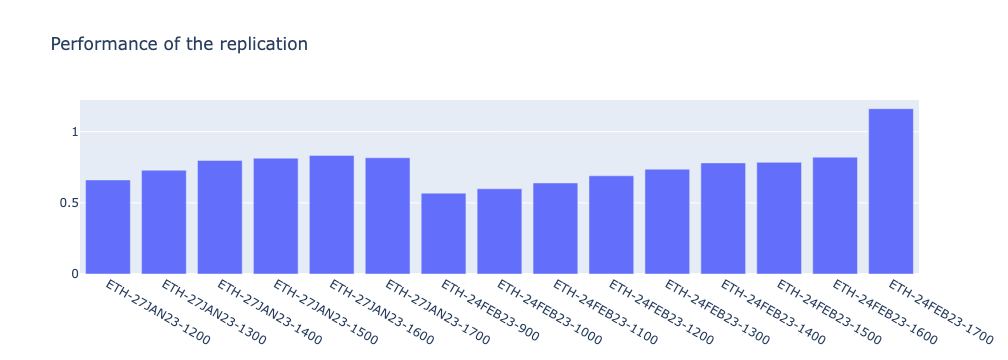

In [284]:
# dices2 = pd.DataFrame(np.random.randint(low=1, high=7, size=(100, 2)), columns=('Кость 1', 'Кость 2'))
# dices2['Сумма'] = dices2['Кость 1'] + dices2['Кость 2']
# dices3 = pd.DataFrame(np.random.randint(low=1, high=7, size=(1000, 2)), columns=('Кость 1', 'Кость 2'))
# dices3['Сумма'] = dices3['Кость 1'] + dices3['Кость 2']

fig = go.Figure(layout = {"title": {"text": "Performance of the replication"}})
# fig.add_trace(go.Histogram(x=dices['Сумма']))
for i in range(len(res)):
    # fig.add_trace(go.Histogram(x=r))
    # fig.add_trace(go.Histogram(x=r))
    fig2 = px.bar(res[i], x=np.array([res[i][0]]), y=np.array([res[i][1]]))
    
    # fig2 = px.bar(df, x="x", y="y")
    fig.add_trace(fig2.data[0])

# fig.add_trace(go.Histogram(x=dices3['Сумма']))
fig.show()